# Dimensionality Reduction of HI Spectra with Variational Autoencoders

# Install packages

In [1]:
# ! pip install astroML

In [2]:
# !pip install torch-lr-finder

In [3]:
# ! pip install pytorch-lightning

# Connect and authorize google drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/
!ls

In [ ]:
! pwd

# Paths

In [9]:
import sys, os
base_path = os.getcwd()

data_path  = os.path.join(base_path, 'data')
vae_path = os.path.join(base_path, 'vae')
vae_data_path = os.path.join(data_path, 'vae', '')

print(base_path)
print(data_path)

/content/gdrive/MyDrive/Colab Notebooks/ML_HI
/content/gdrive/MyDrive/Colab Notebooks/ML_HI/data


In [10]:
training_data_file = 'training_data_kok14_galfa.pickle'
fcnm_cnn_file = 'fcnm_zea.fits'
rhi_cnn_file = 'rhi_zea.fits'
observed_catalog_file = 'catalogged_verification.fits'

training_data_pkl_file = os.path.join(data_path, training_data_file)
print(training_data_pkl_file)

/content/gdrive/MyDrive/Colab Notebooks/ML_HI/data/training_data_kok14_galfa.pickle


# Libraries

In [44]:
sys.path.insert(1, data_path)

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import pickle


# Download data

In [12]:
# Download data (if necessary)
download = False
if download:
    # Training and test spectra
    !wget -O training_data_kok14_galfa.pickle https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/QT6NPF/79N7YU
    # fCNM CNN maps and uncertainties
    !wget -O fcnm_zea.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/E0HLON/28QM9F
    # RHI CNN maps and uncertainties
    !wget -O rhi_zea.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/E0HLON/WJZMPD
    # Observed catalog
    !wget -O catalogged_verification.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/MJGQAY/D2RS4E

# Read training dataset

Training set includes 38781 spectra (1-D spectral data: signal strength T_b as a function of wavelength channels) and their ground-truth cold atomic hydrogen gas fraction (FCNM) and opacity correction factor (R). The training dataset was obtained from a simulation.

FCNM range: from ~0. to (less than) 1.
R range: >= 1

Test dataset consists of 58 spectra from observations.

**Note:** Atomic Hydrogen Gas = HI

In [14]:
print('Reading: %s' % (training_data_pkl_file))
data = pickle.load(open(training_data_pkl_file, 'rb'))

# Synthetic training data
X_train = data['X_train']
Y_train = data['Y_train']

# Observed test data
X_test = data['X_test'] 
Y_test = data['Y_test']

Reading: /content/gdrive/MyDrive/Colab Notebooks/ML_HI/data/training_data_kok14_galfa.pickle


In [23]:
# Training set
nspec_train, nchan = X_train.shape
print('Number of training spectra %i; nchan = %i' % (nspec_train, nchan))
print('Ground-truth data shape: # values = %i; # columns = %i' % (Y_train.shape))

Number of training spectra 38781; nchan = 414
Ground-truth data shape: # values = 38781; # columns = 2


In [24]:
# Cold gas fraction (FCNM) and opacity correction factor (R)
FCNM_train = Y_train[:, 0]
R_train    = Y_train[:, 1]

In [21]:
# Test set
nspec_test, nchan = X_test.shape
print('Number of testing spectra %i; nchan = %i' % (nspec_test, nchan))

Number of testing spectra 58; nchan = 414


In [25]:
# Cold gas fraction (FCNM) and opacity correction factor (R)
FCNM_test = Y_test[:, 0]
R_test    = Y_test[:, 1]

# Plot a few spectra

## Spectra in training set

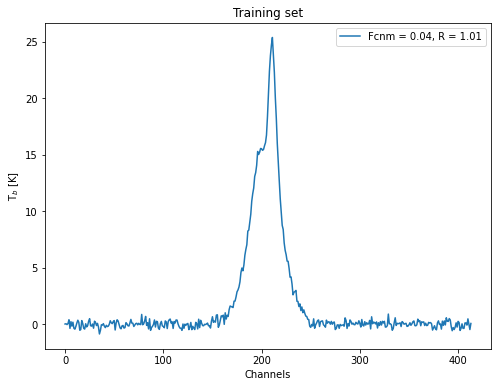

In [27]:
# Spectrum in training set
plt.figure(figsize=(8,6))
plt.plot(X_train[0, :], label=f'Fcnm = {round(FCNM_train[0], 2)}, R = {round(R_train[0], 2)}')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

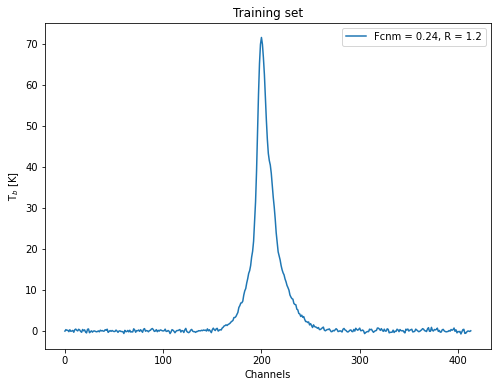

In [28]:
# Spectrum in training set
plt.figure(figsize=(8,6))
plt.plot(X_train[1000, :], label=f'Fcnm = {round(FCNM_train[1000], 2)}, R = {round(R_train[1000], 2)}')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

## Spectra in test set

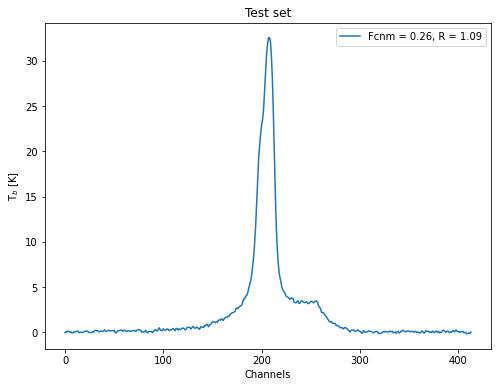

In [29]:
# Spectrum in test set
plt.figure(figsize=(8,6))
plt.plot(X_test[0, :], label=f'Fcnm = {round(FCNM_test[0], 2)}, R = {round(R_test[0], 2)}')

plt.title('Test set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

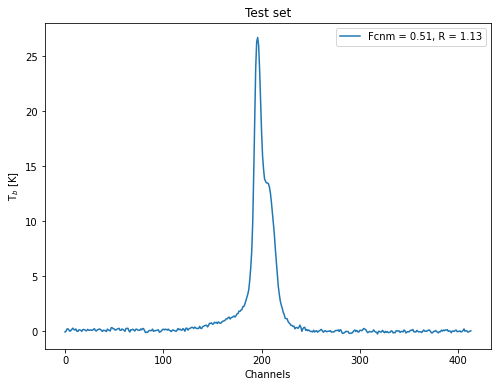

In [31]:
# Spectrum in test set
plt.figure(figsize=(8,6))
plt.plot(X_test[50, :], label=f'Fcnm = {round(FCNM_test[50], 2)}, R = {round(R_test[50], 2)}')

plt.title('Test set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

# Histogram of FCNM and R

**Note:** Atomic Hydrogen Gas = HI

In [33]:
FCNM = Y_train[:, 0]
R    = Y_train[:, 1]

In [47]:
stats_series = pd.DataFrame(FCNM).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
print('FCNM:')
stats_series

FCNM:


,0
count,38781.000000
mean,0.124217
std,0.146359
min,0.000000
25%,0.001239
50%,0.072085
75%,0.194566
max,0.990657


In [48]:
stats_series = pd.DataFrame(R).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
print('R:')
stats_series

R:


,0
count,38781.000000
mean,1.055612
std,0.094703
min,1.000000
25%,1.003454
50%,1.019180
75%,1.065427
max,2.849226


## Cold HI gas fraction: FCNM

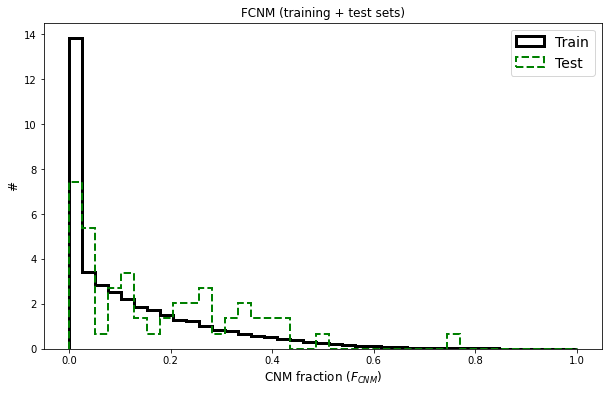

In [38]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(FCNM_train, bins=np.linspace(0., 1., 40),
         density=True, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='Train')

plt.hist(FCNM_test, bins=np.linspace(0., 1., 40),
         density=True, color='g', histtype='step', alpha=1.,
         ls='--', lw=2, label='Test')

plt.title(f'FCNM (training + test sets)')
plt.xlabel(r'CNM fraction ($F_{CNM}$)', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

## HI Opacity correction  Factor : R

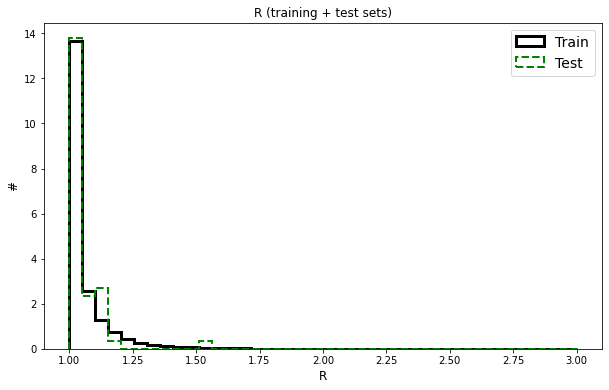

In [54]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(R_train, bins=np.linspace(1., 3., 40),
         density=True, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='Train')

plt.hist(R_test, bins=np.linspace(1., 3., 40),
         density=True, color='g', histtype='step', alpha=1.,
         ls='--', lw=2, label='Test')

plt.title(f'R (training + test sets)')
plt.xlabel(r'R', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

# Check the noise of spectral data

Use standard deviation of the "off-signal-line" channels to estimate the noise of spectral data. Here I use the first 20 channels (where there are no signal lines).

## Training set

In [ ]:
noise_train = X_train[:, 0:20].std(axis=1)
np.where(noise_train > 1.25)[0]

array([ 4004,  4633,  6578,  7694,  8203, 11767, 12070, 13299, 21871,
       22593, 23423, 23707, 24406, 24629, 26222, 27276, 34234, 35594,
       36704])

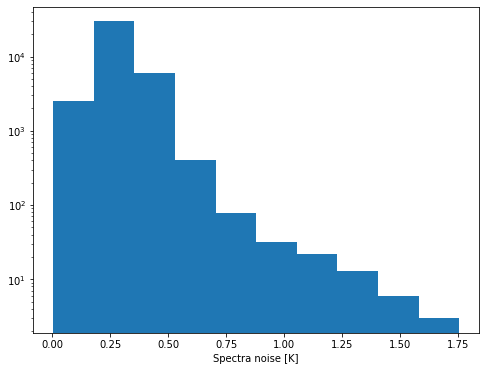

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(noise_train)
plt.yscale('log')
plt.xlabel('Spectra noise [K]')
plt.show()
plt.close()

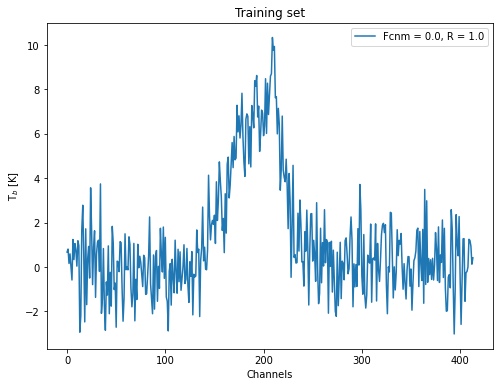

In [ ]:
# Spectrum in training set
plt.figure(figsize=(8,6))
plt.plot(X_train[22593, :], label=f'Fcnm = {round(Y_train[22593, 0], 2)}, R = {round(Y_train[22593, 1], 2)}')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

## Test set

In [ ]:
noise_test = X_test[:, 0:20].std(axis=1)
np.where(noise_test > 0.4)[0]

array([11])

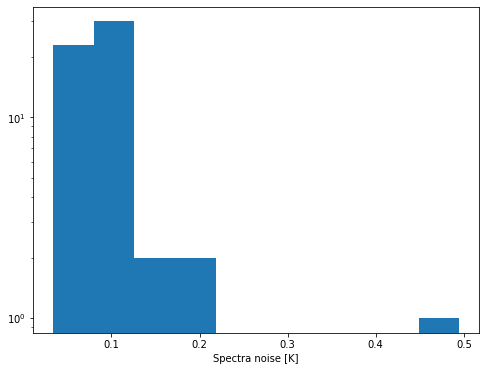

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(noise_test)
plt.yscale('log')
plt.xlabel('Spectra noise [K]')
plt.show()
plt.close()

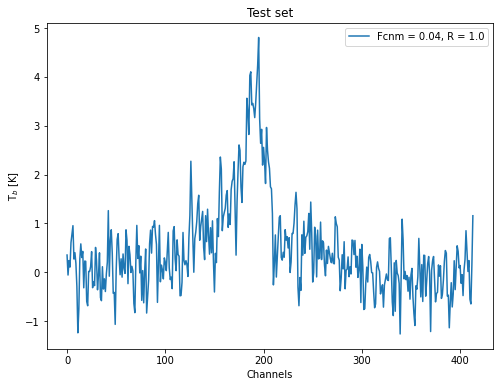

In [ ]:
# Spectrum in test set
plt.figure(figsize=(8,6))
plt.plot(X_test[11, :], label=f'Fcnm = {round(Y_test[11, 0], 2)}, R = {round(Y_test[11, 1], 2)}')

plt.title('Test set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

## Set weights (inverse-variance weights)

In [ ]:
data['noise_train'] = noise_train
data['noise_test'] = noise_test

data['spec_weight_train'] = 1./(noise_train*noise_train + 1./(2e6)) # soften largest weights
data['spec_weight_test'] = 1./(noise_test*noise_test + 1./(2e6))